# Advance Lane Finding : Assignement 2

## The goal of this assignment is to find efficient lane lines present on the roads through camera images.
* Firstly to calibrate the Camera matrix to get the undistorted camera images from Chessboard images.
* The next step is to create a pipeline to find the lanes on an undistorted image through various computer vision techniques.
* The steps include, applying a distortion correction to every image.
* Thresholding the image through color transforms and edge detection techniques.
* Applying a perspective transform to get binary images of only the lanes
* Searching for the binary lines through hough transform and sliding window techniques.
* Determining the curvature and offset from the center of the road. 
* Warp the detected boundaries on the original image.
* The final image should display the lane area and the radius of curvature and the offset.
* A similar pipeline has to be then applied to the videos


# Camera Calibration

In [3]:
import glob
import cv2
import matplotlib.pyplot as plt

import matplotlib.image as mpimg
import numpy as np
import os

In [4]:
path =os.getcwd()
calib_images = sorted(glob.glob('/home/workspace/CarND-Advanced-Lane-Lines/camera_cal/calibration*.jpg'))


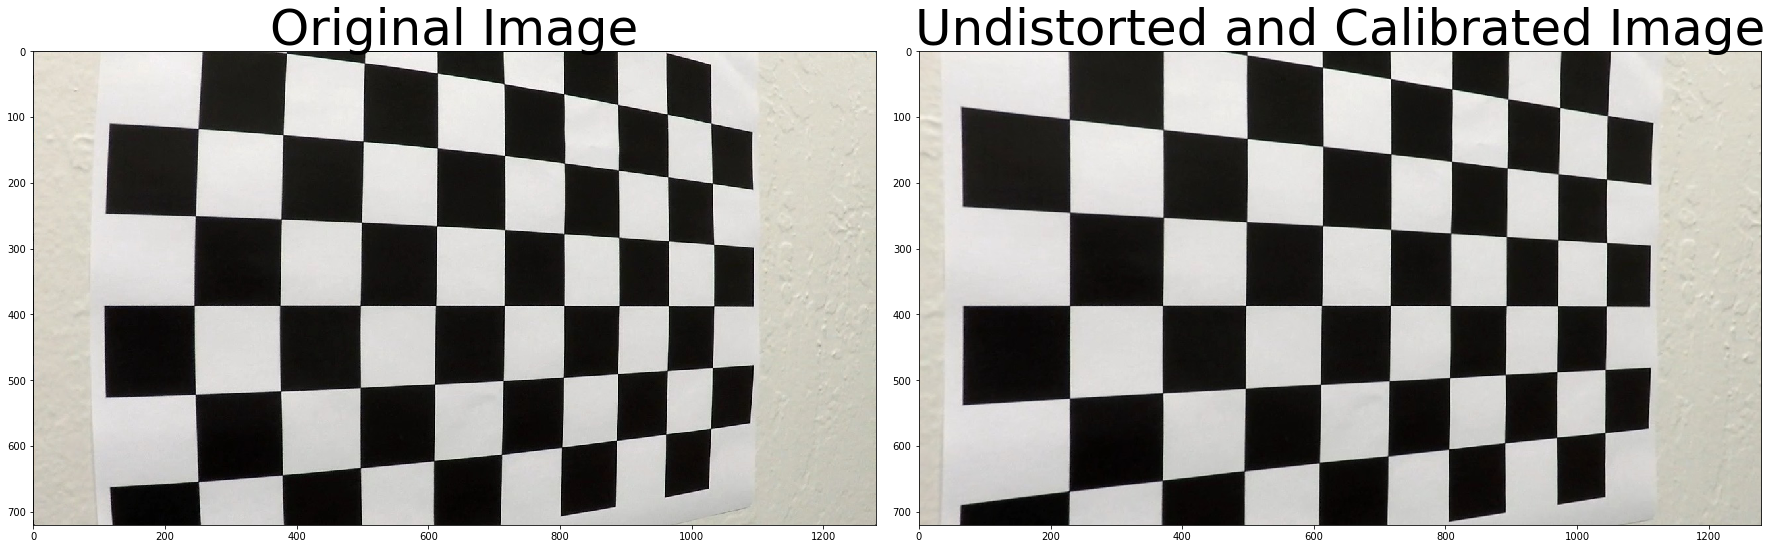

In [5]:
# Calibrate function
def calibrate_fun(calib_images):
    # object points and image points to calibrate
    obj_points =[] # camera points in real world space(3D)
    img_points =[] # points in the image plane (2D)

    objg = np.zeros((6*9,3),np.float32)
    objg[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)


    for i in range(len(calib_images)):
        #read image and convert to grayscale
        img = mpimg.imread(calib_images[i])
        gray = cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)

        # find chessboard corners
        ret, corners = cv2.findChessboardCorners(gray, (9,6), None)

        if ret ==True:
            obj_points.append(objg)
            img_points.append(corners)
    #finds camera matrix
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(obj_points, img_points, gray.shape[::-1], None, None)

    return ret,mtx,dist


_,mtx,dist = calibrate_fun(calib_images)


# A simple Test Case
test_image = mpimg.imread(calib_images[15]) 
dst = cv2.undistort(test_image, mtx, dist, None, mtx) #returns the camers matrix, distortion matrix


f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(test_image)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(dst)
ax2.set_title('Undistorted and Calibrated Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

## Saving the Undistorted images 
# os.mkdir(path+"/output_images/"+"Calibration_result")
# for i in range(len(calib_images)):
#     test_image = mpimg.imread(calib_images[i]) 
#     dst = cv2.undistort(test_image, mtx, dist, None, mtx) #returns the camers matrix, distortion matrix
#     mpimg.imsave(path+"output_images/calibrated"+str(calib_images[i].split("calibration")[1]),dst)

    

# Distortion Correction to test images

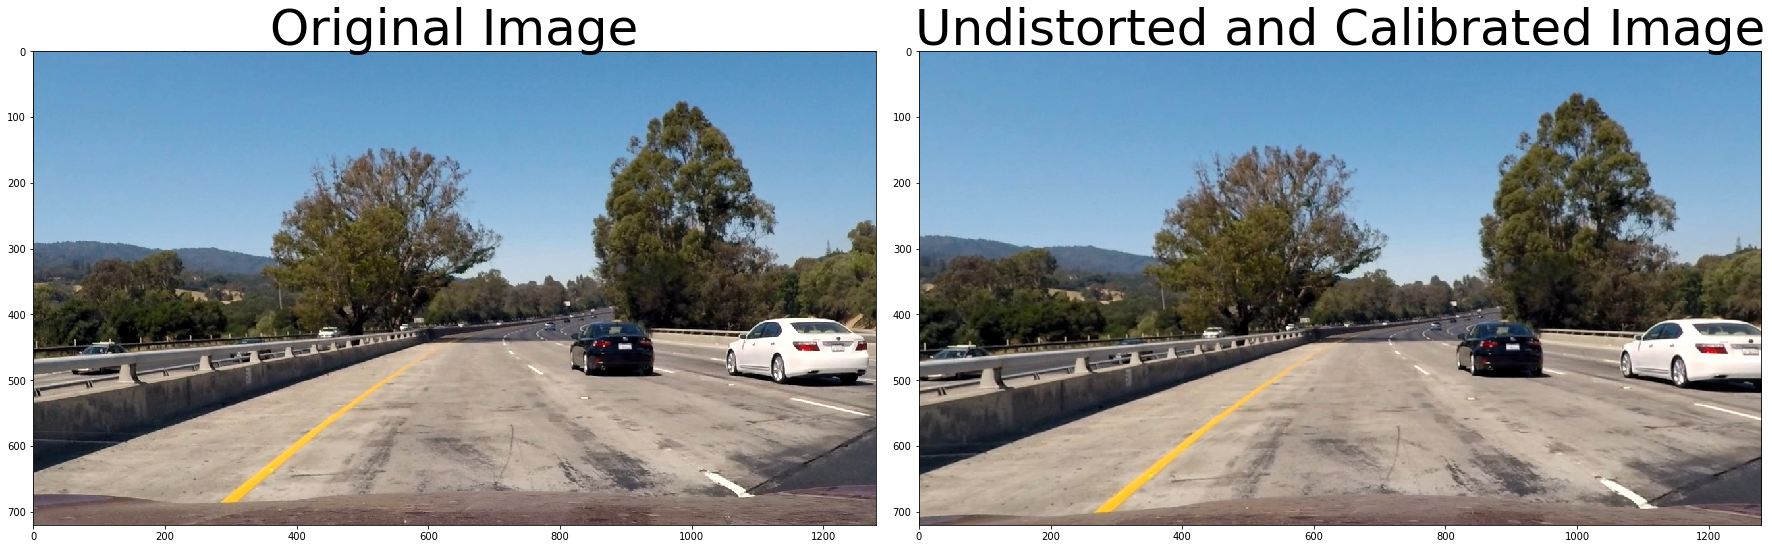

In [6]:
# Applying distortion correction to images in test_images folder and Saving to Distortion_Correction folder 

#os.mkdir(path+"/output_images/"+"Distortion_Correction")
list_images = glob.glob(path+"/test_images/*.jpg")
for i in range(len(list_images[:1])):
    test_image = mpimg.imread(list_images[i]) 
    dst = cv2.undistort(test_image, mtx, dist, None, mtx) #returns the camers matrix, distortion matrix
    #mpimg.imsave(path+"/output_images/Distortion_Correction/"+str(list_images[i].split("/")[-1]),dst)
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
    f.tight_layout()
    ax1.imshow(test_image)
    ax1.set_title('Original Image', fontsize=50)
    ax2.imshow(dst)
    ax2.set_title('Undistorted and Calibrated Image', fontsize=50)
    plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)



   # Pipeline (Test Images)

## Color tranform and thresholding to create a binary image

In [7]:
#requires color image (RGB)
def image_transform(img):
    img_copy = np.copy(img)
    #img = cv2.GaussianBlur(img,(3,3),0)

    img = cv2.undistort(img, mtx, dist, None, mtx)
    # img is the undistorted image. Converting image to HLS color space
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    #Saturation Channel of HLS
    s_channel = hls[:,:,2]

    # Grayscale image
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

    # Sobel x
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0) # Take the derivative in x
    abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))

    # Threshold x gradient
    thresh_min = 20
    thresh_max = 100
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= thresh_min) & (scaled_sobel <= thresh_max)] = 1

    # Threshold color channel
    s_thresh_min = 170
    s_thresh_max = 255
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh_min) & (s_channel <= s_thresh_max)] = 1

    # Stack each channel to view their individual contributions in green and blue respectively
    # This returns a stack of the two binary images, whose components you can see as different colors
    color_binary = np.dstack(( np.zeros_like(sxbinary), sxbinary, s_binary)) * 255

    # Combine the two binary thresholds 
    combined_binary = np.zeros_like(sxbinary)
    combined_binary[(s_binary == 1) | (sxbinary == 1)] = 1
    
    ## Removing very small noise pixels (Probably help in getting lane lines from Histogram)
    nb_components, output, stats, centroids = cv2.connectedComponentsWithStats(combined_binary, connectivity=8)
    sizes = stats[1:, -1]; nb_components = nb_components - 1
    # For every image we keep areas of atleast min_size
    min_size = 30

    combined = np.zeros((output.shape))

    for i in range(0, nb_components):
        if sizes[i] >= min_size:
            combined[output == i + 1] = 1

    
    return combined
    
    

## perspective transform 

In [8]:
def perspective_func(img):
    #source points
    imshape = img.shape
    # source points
    src_points = np.float32([[imshape[1]/6,imshape[0]],[imshape[1]*(5/6),imshape[0]],[imshape[1]/2+60,imshape[0]*0.65],[imshape[1]/2-60,imshape[0]*0.65]])
    # destination points
    offset = imshape[1]*0.25
    dst_points = np.float32([[offset,imshape[0]],[imshape[1]-offset,imshape[0]],[imshape[1]-offset,0],[offset,0]])
   
    img_size = (img.shape[1], img.shape[0])
    #get the perspective transform
    M = cv2.getPerspectiveTransform(src_points, dst_points)
    
    #Inverse transform
    Minv = cv2.getPerspectiveTransform(dst_points, src_points)
    
    #warp an image using perspective tranform
    warped = cv2.warpPerspective(img, M, img_size, flags=cv2.INTER_LINEAR)
    
    return warped,Minv


## Finding the lane pixels through Hough transform and Sliding Window technique

In [9]:
#binary_warped = cv2.imread('/home/ispluser/Preet/Udacity/warped_image.jpg',0)

def find_lane_pixels(binary_warped):
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
    # Create an output image to draw on and visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]//2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # HYPERPARAMETERS
    # Choose the number of sliding windows
    nwindows = 9
    # Set the width of the windows +/- margin
    margin = 40
    # Set minimum number of pixels found to recenter window
    minpix = 20

    # Set height of windows - based on nwindows above and image shape
    window_height = np.int(binary_warped.shape[0]//nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated later for each window in nwindows
    leftx_current = leftx_base
    rightx_current = rightx_base

    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds_X = []
    left_lane_inds_Y = []
    right_lane_inds_X = []
    
    right_lane_inds_Y = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = int(binary_warped.shape[0] - (window+1)*window_height)
        win_y_high = int(binary_warped.shape[0] - window*window_height)
        ### TO-DO: Find the four below boundaries of the window ###
        win_xleft_low = int(leftx_base-margin)
        win_xleft_high = int(leftx_base+margin)  # Update this
        win_xright_low = int(rightx_base-margin)  # Update this
        win_xright_high = int(rightx_base+margin)  # Update this
        
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),
        (win_xleft_high,win_y_high),(0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),
        (win_xright_high,win_y_high),(0,255,0), 2) 
        
        
        ### TO-DO: Identify the nonzero pixels in x and y within the window ###
        nonzero_window_L = binary_warped[win_y_low: win_y_high, win_xleft_low: win_xleft_high].nonzero()
        #print(leftx_base)
        #print(win_xleft_low)
        #print(win_y_low)
        nonzero_X_L = nonzero_window_L[1] + win_xleft_low 
        nonzero_Y_L = nonzero_window_L[0] + win_y_low 
       
        
        nonzero_window_R = binary_warped[win_y_low: win_y_high, win_xright_low: win_xright_high].nonzero()
        nonzero_X_R = nonzero_window_R[1] + win_xright_low 
        nonzero_Y_R = nonzero_window_R[0] + win_y_low  
        good_left_inds = [nonzero_X_L, nonzero_Y_L]
        good_right_inds = [nonzero_X_R, nonzero_Y_R]
        
        # Append these indices to the lists
        left_lane_inds_X.append(good_left_inds[0])
        left_lane_inds_Y.append(good_left_inds[1])
        right_lane_inds_X.append(good_right_inds[0])
        
        right_lane_inds_Y.append(good_right_inds[1])
        
        #print(len(nonzero_X_L))
        if len(nonzero_X_L) > minpix:
            leftx_base = np.mean(nonzero_X_L)
        #print(len(nonzero_X_R))
        if len(nonzero_X_R) > minpix:
            rightx_base = np.mean(nonzero_X_R)

    # Extract left and right line pixel positions
    leftx = np.concatenate(left_lane_inds_X)
    lefty = np.concatenate(left_lane_inds_Y)    #nonzeroy[left_lane_inds] 
    rightx =np.concatenate(right_lane_inds_X)                   #nonzerox[right_lane_inds]
    righty = np.concatenate(right_lane_inds_Y)                        #nonzeroy[right_lane_inds]

    return leftx, lefty, rightx, righty, out_img


def fit_polynomial(binary_warped):
    # Find our lane pixels first
    leftx, lefty, rightx, righty, out_img = find_lane_pixels(binary_warped)
     
    ### TO-DO: Fit a second order polynomial to each using `np.polyfit` ###
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit =  np.polyfit(righty, rightx, 2)

    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0])
    try:
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    except TypeError:
        # Avoids an error if `left` and `right_fit` are still none or incorrect
        print('The function failed to fit a line!')
        left_fitx = 1*ploty**2 + 1*ploty
        right_fitx = 1*ploty**2 + 1*ploty

    ## Visualization ##
    # Colors in the left and right lane regions
#     out_img[lefty, leftx] = [255, 0, 0]
#    out_img[righty, rightx] = [0, 0, 255]

    # Plots the left and right polynomials on the lane lines
    #plt.plot(left_fitx, ploty, color='yellow')
    #plt.plot(right_fitx, ploty, color='yellow')
    # left_fitx are the pixel points 
    return left_fit,left_fitx, right_fit,right_fitx




In [32]:


# def find_lane_pixels(binary_warped):
#     # Take a histogram of the bottom half of the image
#     histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
#     # Create an output image to draw on and visualize the result
#     out_img = np.dstack((binary_warped, binary_warped, binary_warped))
#     # Find the peak of the left and right halves of the histogram
#     # These will be the starting point for the left and right lines
#     midpoint = np.int(histogram.shape[0]//2)
#     leftx_base = np.argmax(histogram[:midpoint])
#     rightx_base = np.argmax(histogram[midpoint:]) + midpoint

#     # HYPERPARAMETERS
#     # Choose the number of sliding windows
#     nwindows = 9
#     # Set the width of the windows +/- margin
#     margin = 40
#     # Set minimum number of pixels found to recenter window
#     minpix = 20

#     # Set height of windows - based on nwindows above and image shape
#     window_height = np.int(binary_warped.shape[0]//nwindows)
#     # Identify the x and y positions of all nonzero pixels in the image
#     nonzero = binary_warped.nonzero()
#     nonzeroy = np.array(nonzero[0])
#     nonzerox = np.array(nonzero[1])
#     # Current positions to be updated later for each window in nwindows
#     leftx_current = leftx_base
#     rightx_current = rightx_base

#     # Create empty lists to receive left and right lane pixel indices
#     left_lane_inds_X = []
#     left_lane_inds_Y = []
#     right_lane_inds_X = []
    
#     right_lane_inds_Y = []

#     # Step through the windows one by one
#     for window in range(nwindows):
#         # Identify window boundaries in x and y (and right and left)
#         win_y_low = int(binary_warped.shape[0] - (window+1)*window_height)
#         win_y_high = int(binary_warped.shape[0] - window*window_height)
#         ### TO-DO: Find the four below boundaries of the window ###
#         win_xleft_low = int(leftx_base-margin)
#         win_xleft_high = int(leftx_base+margin)  # Update this
#         win_xright_low = int(rightx_base-margin)  # Update this
#         win_xright_high = int(rightx_base+margin)  # Update this
        
#         # Draw the windows on the visualization image
#         cv2.rectangle(out_img,(win_xleft_low,win_y_low),
#         (win_xleft_high,win_y_high),(0,255,0), 2) 
#         cv2.rectangle(out_img,(win_xright_low,win_y_low),
#         (win_xright_high,win_y_high),(0,255,0), 2) 
        
        
#         ### TO-DO: Identify the nonzero pixels in x and y within the window ###
#         nonzero_window_L = binary_warped[win_y_low: win_y_high, win_xleft_low: win_xleft_high].nonzero()
#         #print(leftx_base)
#         #print(win_xleft_low)
#         #print(win_y_low)
#         nonzero_X_L = nonzero_window_L[1] + win_xleft_low 
#         nonzero_Y_L = nonzero_window_L[0] + win_y_low 
       
        
#         nonzero_window_R = binary_warped[win_y_low: win_y_high, win_xright_low: win_xright_high].nonzero()
#         nonzero_X_R = nonzero_window_R[1] + win_xright_low 
#         nonzero_Y_R = nonzero_window_R[0] + win_y_low  
#         good_left_inds = [nonzero_X_L, nonzero_Y_L]
#         good_right_inds = [nonzero_X_R, nonzero_Y_R]
        
#         # Append these indices to the lists
#         left_lane_inds_X.append(good_left_inds[0])
#         left_lane_inds_Y.append(good_left_inds[1])
#         right_lane_inds_X.append(good_right_inds[0])
        
#         right_lane_inds_Y.append(good_right_inds[1])
        
#         #print(len(nonzero_X_L))
#         if len(nonzero_X_L) > minpix:
#             leftx_base = np.mean(nonzero_X_L)
#         #print(len(nonzero_X_R))
#         if len(nonzero_X_R) > minpix:
#             rightx_base = np.mean(nonzero_X_R)

#     # Extract left and right line pixel positions
#     leftx = np.concatenate(left_lane_inds_X)
#     lefty = np.concatenate(left_lane_inds_Y)    #nonzeroy[left_lane_inds] 
#     rightx =np.concatenate(right_lane_inds_X)                   #nonzerox[right_lane_inds]
#     righty = np.concatenate(right_lane_inds_Y)                        #nonzeroy[right_lane_inds]

#     return leftx, lefty, rightx, righty, out_img


# def fit_polynomial(binary_warped):
#     # Find our lane pixels first
#     leftx, lefty, rightx, righty, out_img = find_lane_pixels(binary_warped)
     
#     ### TO-DO: Fit a second order polynomial to each using `np.polyfit` ###
#     left_fit = np.polyfit(lefty, leftx, 2,full=True)
#     right_fit =  np.polyfit(righty, rightx, 2,full=True)
#     print("error")
#     print(left_fit[1])
#     print(right_fit[1])
    
#     # Generate x and y values for plotting
#     ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0])
#     try:
#         left_fitx = left_fit[0][0]*ploty**2 + left_fit[0][1]*ploty + left_fit[0][2]
#         right_fitx = right_fit[0][0]*ploty**2 + right_fit[0][1]*ploty + right_fit[0][2]
#     except TypeError:
#         # Avoids an error if `left` and `right_fit` are still none or incorrect
#         print('The function failed to fit a line!')
#         left_fitx = 1*ploty**2 + 1*ploty
#         right_fitx = 1*ploty**2 + 1*ploty
    
#     #error_right = np.sum((np.polyval(np.polyfit(leftx, lefty, 2), leftx) - lefty)**2)
    
#     ## Visualization ##
#     # Colors in the left and right lane regions
# #     out_img[lefty, leftx] = [255, 0, 0]
# #    out_img[righty, rightx] = [0, 0, 255]

#     # Plots the left and right polynomials on the lane lines
#     #plt.plot(left_fitx, ploty, color='yellow')
#     #plt.plot(right_fitx, ploty, color='yellow')
#     # left_fitx are the pixel points 
#     return left_fit[0],left_fitx, right_fit[0],right_fitx




In [ ]:
# # Polynomial fit values from the previous frame


# def fit_poly(img_shape, leftx, lefty, rightx, righty):
#      ### TO-DO: Fit a second order polynomial to each with np.polyfit() ###
#     left_fit = np.polyfit(lefty, leftx, 2)
#     right_fit = np.polyfit(righty, rightx, 2)
#     # Generate x and y values for plotting
#     ploty = np.linspace(0, img_shape[0]-1, img_shape[0])
#     ### TO-DO: Calc both polynomials using ploty, left_fit and right_fit ###
#     left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
#     right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
#     np.sum((np.polyval(np.polyfit(x, y, 2), x) - y)**2)
    
#     return left_fitx, right_fitx, ploty

# def search_around_poly(binary_warped, left_fit, right_fit):
#     # HYPERPARAMETER
#     # Choose the width of the margin around the previous polynomial to search
#     # The quiz grader expects 100 here, but feel free to tune on your own!
#     margin = 100

#     # Grab activated pixels
#     nonzero = binary_warped.nonzero()
#     print(nonzero)
#     nonzeroy = np.array(nonzero[0])

#     nonzerox = np.array(nonzero[1])
    
    
#     ### TO-DO: Set the area of search based on activated x-values ###
#     ### within the +/- margin of our polynomial function ###
#     ### Hint: consider the window areas for the similarly named variables ###
#     ### in the previous quiz, but change the windows to our new search area ###
#     left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + 
#                     left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + 
#                     left_fit[1]*nonzeroy + left_fit[2] + margin)))
#     right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + 
#                     right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + 
#                     right_fit[1]*nonzeroy + right_fit[2] + margin)))
    
#     print(np.sum(left_lane_inds))
#     print(np.sum(right_lane_inds))
#     # Again, extract left and right line pixel positions
#     leftx = nonzerox[left_lane_inds]
#     lefty = nonzeroy[left_lane_inds] 
#     rightx = nonzerox[right_lane_inds]
#     righty = nonzeroy[right_lane_inds]

#     # Fit new polynomials
#     left_fitx, right_fitx, ploty = fit_poly(binary_warped.shape, leftx, lefty, rightx, righty)
    
#     ## Visualization ##
#     # Create an image to draw on and an image to show the selection window
# #     out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
# #     window_img = np.zeros_like(out_img)
# #     # Color in left and right line pixels
# #     out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
# #     out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

# #     # Generate a polygon to illustrate the search window area
# #     # And recast the x and y points into usable format for cv2.fillPoly()
# #     left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
# #     left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, 
# #                               ploty])))])
# #     left_line_pts = np.hstack((left_line_window1, left_line_window2))
# #     right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
# #     right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, 
# #                               ploty])))])
# #     right_line_pts = np.hstack((right_line_window1, right_line_window2))

# #     # Draw the lane onto the warped blank image
# #     cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
# #     cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
# #     result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
    
# #     # Plot the polynomial lines onto the image
# #     plt.plot(left_fitx, ploty, color='yellow')
# #     plt.plot(right_fitx, ploty, color='yellow')
#     ## End visualization steps ##
    
#     return left_fitx, right_fitx



## Measuring the Radius of Curvature

In [10]:
def measure_curvature_pixels(_left_fit,left_fitx, _right_fit, right_fitx):
    
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    ploty = np.linspace(0, 719, num=720)

    # Define y-value where we want radius of curvature
    # We'll choose the maximum y-value, corresponding to the bottom of the image
    y_eval = np.max(ploty)
    left_fit = np.polyfit(np.int32(ploty)*ym_per_pix, np.int32(left_fitx)*xm_per_pix, 2)
    right_fit = np.polyfit(np.int32(ploty)*ym_per_pix, np.int32(right_fitx)*xm_per_pix, 2)

    
    # Calculation of R_curve (radius of curvature)
    left_curverad = ((1+(2*left_fit[0]*y_eval*ym_per_pix+ left_fit[1])**2)**1.5)/np.abs(2*left_fit[0])  
    right_curverad = ((1+(2*right_fit[0]*y_eval*ym_per_pix+ right_fit[1])**2)**1.5)/np.abs(2*right_fit[0]) 
    return left_curverad, right_curverad

## Offset from the center of the lane

In [11]:
def measure_offset(left_fit, right_fit, img):
    # sending a colored channel image
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    imshape = img.shape[:2]
    r = imshape[1]-1
    left = np.polyval(left_fit,r*ym_per_pix)
    right = np.polyval(right_fit, r*ym_per_pix)
    return  (r/2- (right+left)/2)*xm_per_pix

In [12]:
def show_text(result,radius_of_curvature, offcenter):
    fontscale = 1.8
    thickness1 = 10
    thickness2 = 6
    color1 = (0, 0, 0)
    color2 = (255, 255, 255)

    cv2.putText(result, 'Radius of curvature:', (20,60), cv2.FONT_HERSHEY_SIMPLEX, fontscale, color1, thickness1, cv2.LINE_AA)
    cv2.putText(result, 'Radius of curvature:', (20,60), cv2.FONT_HERSHEY_SIMPLEX, fontscale, color2, thickness2, cv2.LINE_AA)
    cv2.putText(result, '{0:>10.3f} m'.format(radius_of_curvature), (700,60), cv2.FONT_HERSHEY_SIMPLEX, fontscale, color1, thickness1, cv2.LINE_AA)
    cv2.putText(result, '{0:>10.3f} m'.format(radius_of_curvature), (700,60), cv2.FONT_HERSHEY_SIMPLEX, fontscale, color2, thickness2, cv2.LINE_AA)

    cv2.putText(result, 'Offset(neg-left, pos-right):', (20,130), cv2.FONT_HERSHEY_SIMPLEX, fontscale, color1, thickness1, cv2.LINE_AA)
    cv2.putText(result, 'Offset(neg-left, pos-right):', (20,130), cv2.FONT_HERSHEY_SIMPLEX, fontscale, color2, thickness2, cv2.LINE_AA)
    cv2.putText(result, '{0:>+10.3f} m'.format(offcenter), (700,130), cv2.FONT_HERSHEY_SIMPLEX, fontscale, color1, thickness1, cv2.LINE_AA)
    cv2.putText(result, '{0:>+10.3f} m'.format(offcenter), (700,130), cv2.FONT_HERSHEY_SIMPLEX, fontscale, color2, thickness2, cv2.LINE_AA)


## Function for Images

offset
-0.568194466901


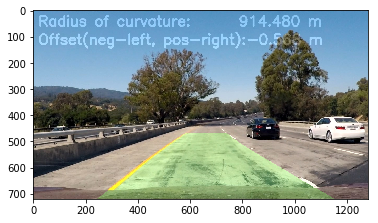

In [14]:
list_images = glob.glob(path+"/test_images/*.jpg")

for i in range(len(list_images[:1])):
    # read the test image
    image = mpimg.imread(list_images[i])
    imshape = image.shape
    # creating a copy image for future use
    img = np.copy(image)
    undis_img = cv2.undistort(image, mtx, dist, None, mtx)
    # binarising the image
    img_trans = image_transform(undis_img)
    # perspective transform to get the rectified image containing only lanes
    img_pers,Minv = perspective_func(img_trans)
    # fit polynomial results in the lane curves
    left_fit ,left_fitx,right_fit, right_fitx = fit_polynomial(img_pers)
    # radius of curvature
    left_curvature, right_curvature = measure_curvature_pixels(left_fit, left_fitx, right_fit, right_fitx)
    
    radius_of_curvature = (left_curvature + right_curvature)/2
    # offset from the center of the lane
    offset = measure_offset(left_fit, right_fit, image)
    
    ploty = np.linspace(0, 719, num=720)
    # creating binary warped image
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))
    warp_zero = np.zeros(img.shape[:2], dtype=np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    cv2.fillPoly(color_warp, np.int_([pts]), (0, 255, 0))
    img_warp =cv2.warpPerspective(color_warp, Minv, (1280,720), flags=cv2.INTER_LINEAR)    
    print("offset")
    print(offset)
    show_text(img_warp,radius_of_curvature,offset)
    result = cv2.addWeighted(img, 1, img_warp, 0.2, 0)
    plt.imshow(result)
    plt.show()


# Pipeline for Videos

In [21]:
def func_videos(image):
    imshape = image.shape
    # creating a copy image for future use
    img = np.copy(image)
    undis_img = cv2.undistort(image, mtx, dist, None, mtx)
    # binarising the image
    img_trans = image_transform(undis_img)
    # perspective transform to get the rectified image containing only lanes
    img_pers,Minv = perspective_func(img_trans)
    # fit polynomial results in the lane curves
    left_fit ,left_fitx,right_fit, right_fitx = fit_polynomial(img_pers)
    # radius of curvature
    left_curvature, right_curvature = measure_curvature_pixels(left_fit, left_fitx, right_fit, right_fitx)
    
    radius_of_curvature = (left_curvature + right_curvature)/2
    # offset from the center of the lane
    offset = measure_offset(left_fit, right_fit, image)

    ploty = np.linspace(0, 719, num=720)
    # creating binary warped image
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))
    warp_zero = np.zeros(img.shape[:2], dtype=np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    cv2.fillPoly(color_warp, np.int_([pts]), (0, 255, 0))
    img_warp =cv2.warpPerspective(color_warp, Minv, (1280,720), flags=cv2.INTER_LINEAR)    


    show_text(img_warp,radius_of_curvature,offset)
    result = cv2.addWeighted(img, 1, img_warp, 0.3, 0)
    return result



In [116]:

# flag =0 
# count= 0

# def func_videos(image):
#     global count
#     print(count)
#     count=count+1
#     global flag
#     imshape = image.shape
#     # creating a copy image for future use
#     img = np.copy(image)
#     undis_img = cv2.undistort(image, mtx, dist, None, mtx)
#     # binarising the image
#     img_trans = image_transform(undis_img)
#     # perspective transform to get the rectified image containing only lanes
    
#     img_pers,Minv = perspective_func(img_trans)
#     plt.imshow(img_pers)
#     plt.show()
# #     print(img_pers.nonzero())
#     # fit polynomial results in the lane curves
 
#  #           if flag==0:
# #         print("i am in if")
# #         global left_fit, right_fit, left_fitx, right_fitx
# #         left_fit ,left_fitx, right_fit, right_fitx = fit_polynomial(img_pers)
# #         print(left_fit)
# #         print(right_fit)
# #     else:
#         #print("in else")
#     global left_fit, right_fit
#     if flag ==0:
#         left_fit =  [  3.48686910e-04,  -6.19694348e-01,   6.80580752e+02]
#         right_fit = [  2.43719425e-04,  -3.38540636e-01,   1.11070183e+03]
    
#     left_fit, right_fit = search_around_poly(img_pers, left_fit, right_fit)
#     flag=1    
    
#     # radius of curvature
#     left_curvature, right_curvature = measure_curvature_pixels(left_fit, right_fit)
#     # offset from the center of the lane
#     offset = measure_offset(left_fit, right_fit, image)

#     ploty = np.linspace(0, 719, num=720)
#     # creating binary warped image
#     pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
#     pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
#     pts = np.hstack((pts_left, pts_right))
#     warp_zero = np.zeros(img.shape[:2], dtype=np.uint8)
#     color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

#     cv2.fillPoly(color_warp, np.int_([pts]), (0, 255, 0))
#     img_warp =cv2.warpPerspective(color_warp, Minv, (1280,720), flags=cv2.INTER_LINEAR)    


#     show_text(img_warp,left_curvature, right_curvature,offset)
#     result = cv2.addWeighted(img, 1, img_warp, 0.3, 0)
#     return result



In [22]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML
def load_test_video(file_name='project_video.mp4'):
    images=[]
    count=0
    
    def convert_frame(img):
        nonlocal count
        #img=cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        f="%s - %d" % (file_name, count)
        count += 1
        return (f,img)
    
    clip = VideoFileClip(file_name).subclip(0,5)
    images = [convert_frame(frame) for frame in clip.iter_frames(progress_bar=True)]
    
    return images

# b= mpimg.imread(list_images[0])
# a = cv2.undistort(b, mtx, dist, None, mtx)
# a = image_transform(a)
# out = perspective_func(a)

In [23]:
images =load_test_video()

 99%|█████████▉| 125/126 [00:01<00:00, 63.94it/s]


In [29]:
white_output = 'test_images/project_video_output.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)
clip1 = VideoFileClip('project_video.mp4').subclip(0,20)
white_clip = clip1.fl_image(func_videos) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video test_images/project_video_output.mp4
[MoviePy] Writing video test_images/project_video_output.mp4




  0%|          | 0/501 [00:00<?, ?it/s]

  0%|          | 1/501 [00:00<02:46,  3.01it/s]

  0%|          | 2/501 [00:00<02:48,  2.96it/s]

  1%|          | 3/501 [00:01<02:48,  2.96it/s]

  1%|          | 4/501 [00:01<02:43,  3.03it/s]

  1%|          | 5/501 [00:01<02:41,  3.07it/s]

  1%|          | 6/501 [00:01<02:38,  3.12it/s]

  1%|▏         | 7/501 [00:02<02:34,  3.21it/s]

  2%|▏         | 8/501 [00:02<02:33,  3.21it/s]

 31%|███       | 155/501 [00:54<02:04,  2.77it/s]


 62%|██████▏   | 309/501 [01:50<01:11,  2.69it/s]


 92%|█████████▏| 463/501 [02:53<00:15,  2.41it/s]


100%|█████████▉| 500/501 [03:08<00:00,  2.25it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_images/project_video_output.mp4 

CPU times: user 2min 18s, sys: 592 ms, total: 2min 18s
Wall time: 3min 11s


In [30]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))